In [1]:
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from sklearn.datasets import fetch_openml

In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [5]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist["data"], mnist["target"]

In [7]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Saving figure some_digit_plot


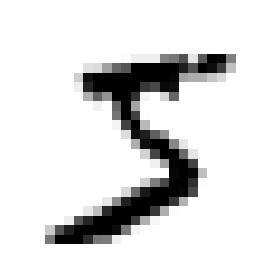

In [8]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [9]:
y[0]

'5'

In [10]:
y = y.astype(np.uint8)

In [11]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

## İkili Sınıflandırıcı Eğitmek

In [12]:
# 5 dedektörü

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
y_train_5[:10]

array([ True, False, False, False, False, False, False, False, False,
       False])

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

## Performans Ölçütleri

### 1.1 Çapraz Doğrulama

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    
    X_train_fold = X_train[train_index]
    X_test_fold = X_train[test_index]
    
    y_train_fold = y_train_5[train_index]
    y_test_fold = y_train_5[test_index]
    
    # =====================================
    
    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred))

0.9701
0.9614
0.9586


In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [19]:
# sınıflandırıcının "5 değil" sınıfını değerlendirmesi

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype="bool")

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 1.2 Hata Matrisi

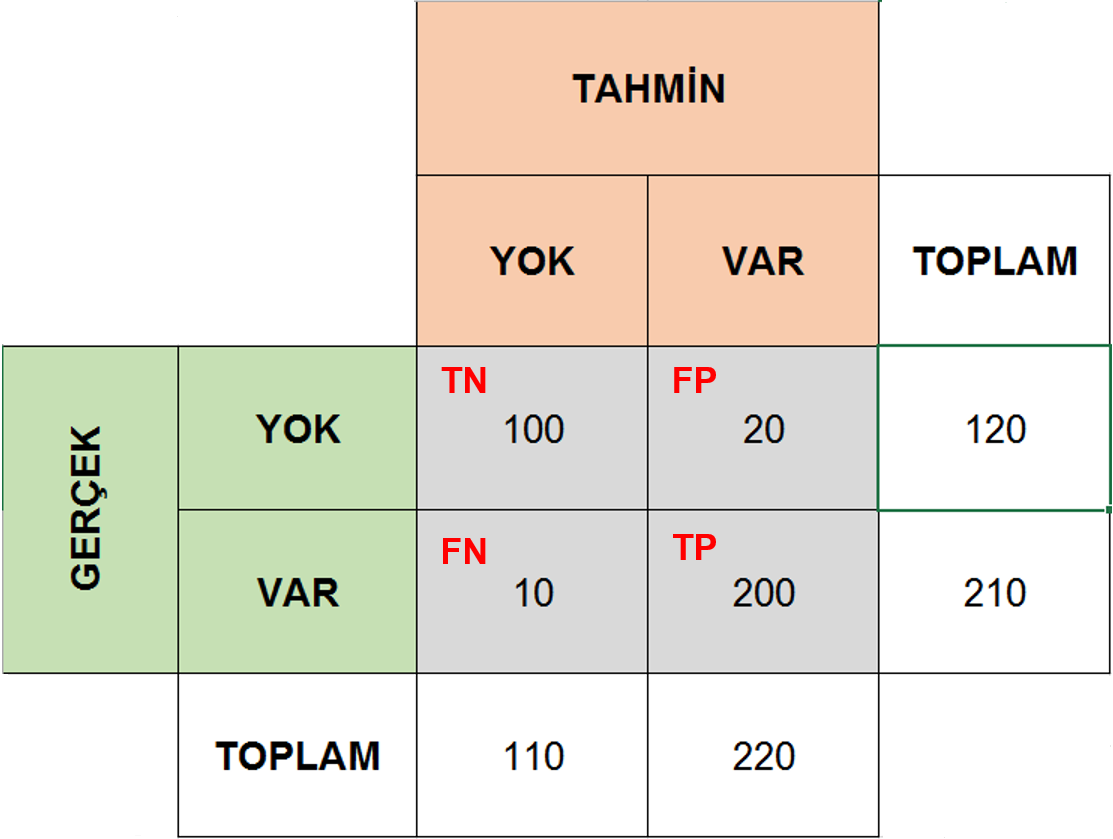

- Doğruya doğru demek (True Positive – TP) **DOĞRU**<br><br>
- Yanlışa yanlış demek (True Negative – TN) **DOĞRU**<br><br>
- Doğruya yanlış demek (False Positive – FP) **YANLIŞ**<br><br>
- Yanlışa doğru demek(False Negative – FN) **YANLIŞ**

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- `cross_val_score()` fonksiyonunda olduğu gibi `cross_val_predict()` de K parça çapraz doğrulama yapar. Ama bu defa her parçanın değerlendirme skorları yerine tahminlerini döndürür.
- İşin önemli noktası ise bu veri setindeki her örnek için temiz bir tahmin alınacaktır, çünkü tahmin yapan model bu veriyi hiç görmeyecektir.
- Artık `confusion_matrix()` ile hata matrisi alınabilir:

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Hata matrisindeki her satır gerçek sınıfı, her sütun ise tahmin edilen sınıfı temsil eder.

In [23]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### 1.3 Kesinlik ve Duyarlılık

$kesinlik = \frac{GP}{GP + YP}$<br><br>
$duyarlılık = \frac{GP}{GP + YN}$

In [24]:
from sklearn.metrics import precision_score, recall_score

In [25]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [26]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- $F_1$ skoru kesinlik ve duyarlılığın harmonik ortalamasıdır.

$F_1 skoru = \frac{2}{\frac{1}{kesinlik} + \frac{1}{duyarlılık}} = 2 x \frac{kesinlik x duyarlılık}{kesinlik + duyarlılık} = \frac{GP}{GP + \frac{YN + YP}{2}}$

In [27]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 1.4 Kesinlik/Duyarlılık Dengesi

- Bu dengeyi anlamak için `SGDClassifier`ın sınıflandırma kararını nasıl aldığına bakalım.
    1. Her bir örnek için *karar fonksiyonu* `decision_function()` kullanarak bir skor hesaplar.
    2. Eğer bu skor bir eşik değerin üstündeyse **pozitif sınıfa** değilse **negatif sınıfa** atar.<br><br>
- Eşik değerin iki beşin ortasındaki ok olduğunu düşünün. 
    - Eşiğin sağında olan 4 tane gerçek pozitif (gerçek 5) ve 1 tane yanlış pozitif (gerçekte 6) olduğu görülüyor.
    - Dolayısıyla seçilen eşik değer için kesinlik %80 (5 taneden 4'ü) olur.
    - Ama toplam 6 gerçek 5'in sadece 4'ünü tespit ettiğinden duyarlılık %67 olur (6 taneden 4'ü).<br><br>
- Eğer eşik değer yükseltilirse (oku sağa taşıyacak olursak) yanlış pozitif olan 6 gerçek negatif ve kesinlik (bu durumda %100 olur) artar. Ama bir gerçek pozitif yanlış negatif olur ve duyarlılık %50'ye düşer.<br><br>
- Diğer durumda ise eşik değeri düşürmek duyarlılığı arttırır ve kesinliği düşürür.

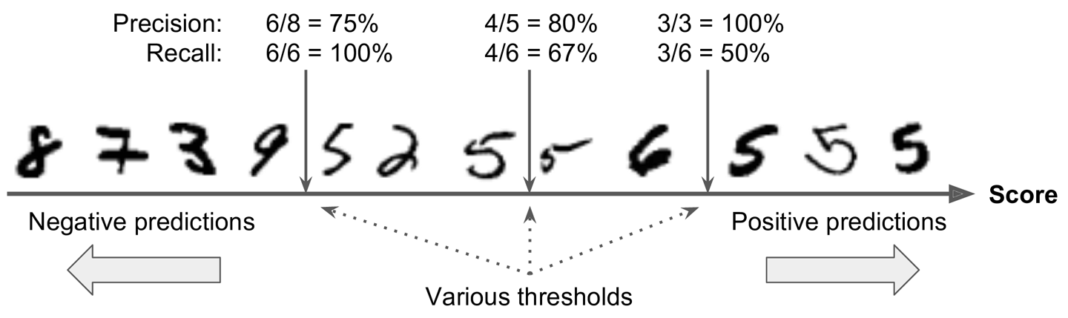

scikit-learn doğrudan eşik değerin seçilmesine izin vermez ancak tahmin yaparken kullandığı skorlara erişmemize izin verir.<br>
`predict()` metodunu çağırmak yerine `decision_function()` metodunu çağırarak her örnek için skorları döndürür ve böylece o skorlara dayanarak istediğiniz eşik değeri kullanıp tahmin yapabilirsiniz.

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [30]:
y_some_digit_pred

array([ True])

`SGDClassifier` eşik değerini 0 olarak kullanır. Sonuç olarak önceki kod `predict()` metoduyla aynı sonuçları döndürür (`True`). Şimdi de eşik değerini arttıralım:

In [31]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Bu, eşik değerin arttırılmasının duyarlılığı azalttığını doğrular. Resim gerçekten bir 5'e ait ve eşik değeri 0 iken sınıflandırıcı bunu tahmin ediyor ancak eşik değeri 8000 iken tespit edemiyor.

Hangi eşik değerini kullanmamız gerektiğine nasıl karar vereceğiz? Önce `cross_val_predict()` fonksiyonunu kullanarak eğitim veri setindeki her bir örneğin skorunu alın. Ama bu sefer tahminler yerine skorlarını döneceğini tanımlayın.

In [32]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function")

Bu skorlarla `precision_recall_curve()` fonksiyonunu kullanarak duyarlılık ölçütlerini hesaplayalım.

In [33]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


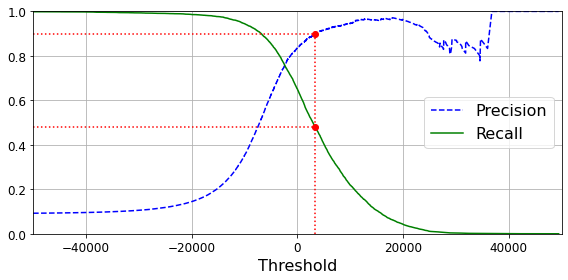

In [34]:
# kesinliği ve duyarlığı eşik değerin bir fonksiyonu olarak çizdirme

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16) 
    plt.grid(True)  
    plt.axis([-50000, 50000, 0, 1]) 
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
save_fig("precision_recall_vs_threshold_plot")                                              
plt.show()

`np.argmax()` en büyük değerin ilk indeksini verir, bu durumda ilk `True` değeridir.

In [35]:
# duyarlılığın %90 olduğu değer
print(recall_90_precision)

# kesinliğin %90 olduğu eşik değer
print(threshold_90_precision)

0.4799852425751706
3370.0194991439566


Saving figure precision_vs_recall_plot


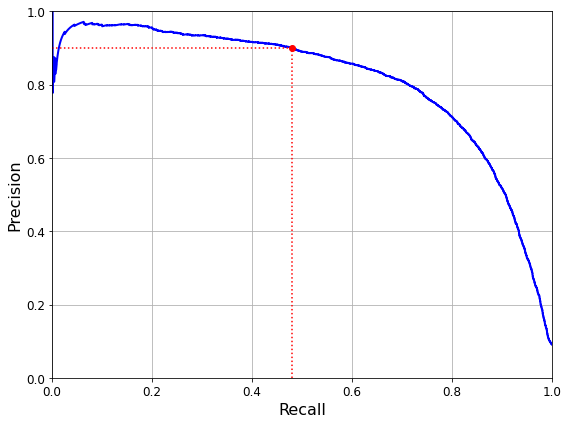

In [36]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [37]:
(y_train_pred == (y_scores > 0)).all()

True

In [38]:
# Eğitim veri setinde tahmin oluşturmak için sınıflandırıcının predict() metodu
# yerine bu yapılabilir

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [39]:
# Tahminlerin kesinliği ve duyarlılığı

print(f"Precision Score: {precision_score(y_train_5, y_train_pred_90)}")
print(f"Recall Score: {recall_score(y_train_5, y_train_pred_90)}")

Precision Score: 0.9000345901072293
Recall Score: 0.4799852425751706


**NOT:** İstediğiniz kesinliğe sahip bir sınıflandırıcı seçmek isterseniz yeterince yüksek bir eşik değer (threshold) seçilmelidir.

### 1.5 ROC Eğrisi

- ROC *(receiver operating characteristic)* eğrisi ikili sınıflandırıcılar için yaygın kullanılan bir araçtır.<br><br>
- ROC eğrisi, *gerçek pozitif oranını* (TPR — duyarlılık) *yanlış pozitif oranına* (FPR) böler.<br><br>
- FPR negatif örneklerden yanlışlıkla pozitif olarak sınıflandırılanların oranıdır ve 1 - *gerçek negatif oranına* (TNR) eşittir.
    - TNR negatif örneklerden doğru olarak negatif sınıflandırılanların oranıdır.
    - TNR, aynı zamanda *özgüllük* olarak adlandırılır.<br><br>
- Dolayısıyla ROC eğrisi, *hassasiyeti* (duyarlılık) 1 - TNR'ye göre çizdirir. 

In [40]:
# ROC eğrisini çizmek için farklı eşik değerlerinde TPR ve FPR'yi 
# hesaplamak için önce roc_curve() kullanılmalı

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


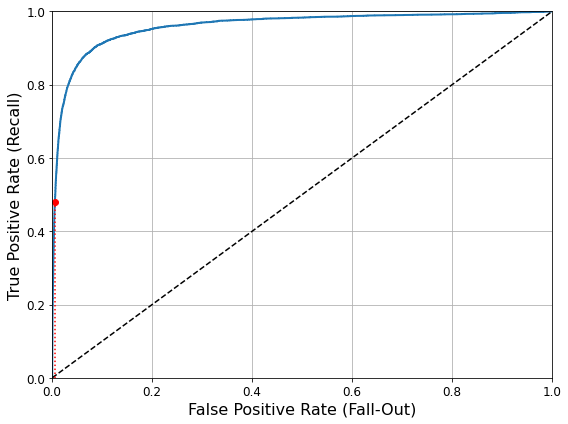

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")               
save_fig("roc_curve_plot")                                    
plt.show()

Kesikli çizgi tamamen rastgele bir sınıflandırıcının ROC eğrisidir ve iyi bir sınıflandırıcı o çizgiden olabildiğince uzak durmalıdır (sol üst köşeye doğru).<br>
Sınıflandırıcıları karşılaştırmanın bir yolu da *eğrinin altında kalan alanı* (AUC) hesaplamaktır. Mükemmel bir sınıflandırıcının değeri 
> $\frac{ROC}{AUC} = 1$ olmalıdır.

In [42]:
# yüksek duyarlılık (TPR) sınıflandırıcının daha fazla yanlış pozitif
# (FPR) üretmesine neden oluyor. 

# ROC - AUC değerini hesaplamak için

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Şimdi bir `RandomForestClassifier` eğitelim ve  ROC eğrisini ROC-AUC skorunu `SGDClassifier`'ınkilerle kıyaslayalım.<br>
önce veri setindeki her örneğin skoruna ihtiyacımız var (`decision_function()`) ancak `RandomForestClassifier` sınıfının çalışma yöntemine göre `decision_function()` metoduna sahip değildir. Onun yerine `predict_proba()` metodu vardır.<br>
> **NOT:** Scikit-Learn sınıflandırıcıları `decision_function()` ve `predict_proba()` fonksiyonlarının ya birine ya da her ikisine de sahiptir.

In [43]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method="predict_proba")

In [44]:
# predict_proba() metodu her satırında bir örnek ve her sütununda 
# bir sınıf için örneğin o sınıfa ait olma olasılığını belirten bir
# dizi döndürür.

y_probas_forest[:5]

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.99, 0.01]])

`roc_curve()` fonksiyonu etiketleri ve skorları beklediğinden skorlar yerine sınıf olasılık değerleri verilebilir. Şimdi pozitif sınıf olasılıklarını skor olarak verelim.

In [45]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Saving figure roc_curve_comparison_plot


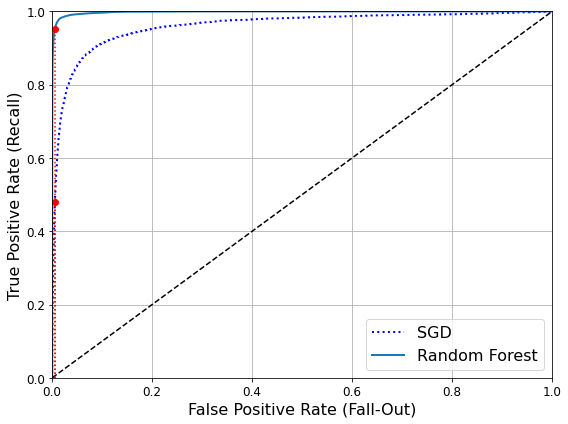

In [46]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

`RandomForestClassifier`'ın ROC eğrisi `SGDClassifier`'ınkine üstün gelmektedir. Yukarıda da görüldüğü gibi `RandomForestClassifier`'ın çizdiği eğrinin, sol üst köşeye daha çok yaklaştığı bellidir ve bu şekilde de AUC değeri de daha yüksek çıkar.

In [47]:
# RandomForestClassifier'ın ROC - AUC skoru
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [48]:
# RandomForestClassifier'ın kesinlik ve duyarlılık skorları

y_pred_forest_predict = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

print(f"Kesinlik: {precision_score(y_train_5, y_pred_forest_predict)}")
print(f"Duyarlılık: {recall_score(y_train_5, y_pred_forest_predict)}")

Kesinlik: 0.9905083315756169
Duyarlılık: 0.8662608374838591


## Çok Sınıflı Sınıflandırma

- Bazı algoritmalar (SGD sınıflandırıcı, Rastgele Orman sınıflandırıcı ve Naif Bayes sınıflandırıcı gibi) çokulu sınıflarla çalışmaya uygundurlar.<br><br>
- Bazı algoritmalar ise (Lojistik bağlanım ya da Destek Vektör Makineleri gibi) sadece ikili sınıflandırıcıdır.<br><br>
- Ancak birden çok ikili sınıflandırıcı kullanarak çok sınıflı sınıflandırma yapabilmek için bazı stratejiler vardır.
    - Rakam resimlerini 10'ar sınıfta (0'dan 9'a kadar) sınıflandıran bir sistem oluşturmanın bir yolu her bir rakamı tespit eden (0 dedektörü, 1 dedektörü, 2 dedektörü, vb.) 10 tane sınıflandırıcı eğitmektir.<br><br>
    - Daha sonra bir resmi sınıflandırmak isterseniz, her bir sınıfın karar fonksiyonunu alıp o resim için karar fonksiyonu en yüksek olan sınıfı seçersiniz. Buna *bire-karşı-diğerleri* (OvR) stratejisi denir.<br><br>
    - Bir diğer strateji ise her rakam çifti için ikili sınıflandırıcı eğitmektir (biri 0 ve 1'leri ayıracak, biri 2 ve 3'leri, vb.). Bu ise *bire-karşı-bir* (OvO) stratejisi olarak adlandırılır. Eğer $N$ tane sınıf varsa 
    > $\frac{N x (N - 1)}{2}$

    tane sınıflandırıcı eğitmeniz gerekecektir.<br><br>
    - MNIST veri seti için 45 adet ikili sınıflandırıcı eğitmek gerekir. Bir resmi sınıflandırmak istediğinizde 45 adet sınıflandırıcıdan da geçirip hangi sınıfın daha çok kazandığına bakmalısınız.<br><br>
    - OvO'nun en önemli avantajı, her sınıflandırıcının sadece ayırt etmesi beklenen iki sınıfın verileriyle eğitilmesidir.

**NOT:** (Destek Vektör Makineleri gibi) bazı sınıflandırıcıların veri seti büyüdüğünde performansı düşer. Bu tip algoritmalarda OvO tercih edilir. Çünkü küçük veri setlerinde çok sınıflandırıcı eğitmek, büyük veri setlerinde az sınıflandırıcı eğitmekten daha hızlıdır. Ancak çoğu ikili sınıflandırıcı için OvR tercih edilir.

In [49]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # çoklu sınıflandırma

SVC()

In [50]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Scikit-learn, çoklu sınıflandırma problemlerinde ikili sınıflandırma algoritmaları tercih ettiğinizi tespit eder ve ona göre bir strateji belirler. Yukarıda "5 ve 5 değil" yerine "0'dan 9'a" gerçek sınıfları kullanarak SVC eğitir. Yani sklearn arkaplanda OvO stratejisini takip etti. 45 adet ikili sınıflandırıcı eğitti.

`decision_function()`metodunu çağırdığınızda her örnek için 10 skor (sadece 1 tane döndürmek yerine) döndürür.

In [51]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [52]:
# en yüksek skor

np.argmax(some_digit_scores)

5

In [53]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Eğer Scikit-Learn'ü bire-karşı-bir ya da bire-karşı-diğerleri kullanmaya zorlamak isterseniz `OneVsOneClassifier` ya da `OneVsRestClassifier` sınıflarını kullanırsınız.<br><br>
Basitçe sınıfın bir örneğini oluşturun ve sınıflandırıcının (ikili sınıflandırıcı olmak zorunda değil) kurucu metoduna gönderin.

In [54]:
# OvR stratejisini kullanan SVC temelli bir çok sınıflı
# sınıflandırıcı oluşturur.

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=999))
ovr_clf.fit(X_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=999))

In [55]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
len(ovr_clf.estimators_)

10

`SGDClassifier` (ya da `RandomForestClassifier`) eğitmek çok basittir:

In [57]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [58]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

`sgd_clf` guesses the 5 as 3 for some reason :p

Bu sefer Scikit-Learn OvR ya da OvO çalıştırmak zorunda kalmadı. Çünkü SGD sınıflandırıcı örnekleri direkt çok sınıfa sınıflandırabilir. Bu sefer `decision_function()` metodu her sınıf için bir değer döndürüyor. Şimdi SGD sınıflandırıcının her sınıfa atadığı değerlere bakalım.

In [59]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [60]:
sgd_clf_cvs = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [61]:
sgd_clf_cvs

array([0.87365, 0.85835, 0.8689 ])

In [62]:
# girdileri ölçekleyerek eğitilen modelin doğruluk oranı

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [63]:
sgd_clf_cvs_xTrained = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, 
                                       scoring="accuracy")

In [64]:
sgd_clf_cvs_xTrained

array([0.8983, 0.891 , 0.9018])

## Hata Analizi

In [65]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [66]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

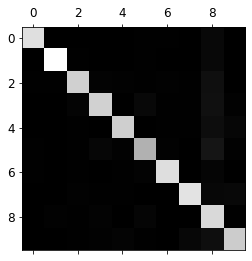

In [67]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [68]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

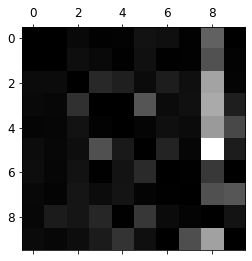

In [69]:
# köşegeni 0'la doldurup sadece hatalar alınsın

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

- Yukarıda satırlar gerçek değerleri, sütunlar tahmini değerleri göstermektedir.
- Sınıf 8'e ait olan sütun oldukça parlak ki bu birçok görüntünün yanlışlıkla 8 olarak sınıflandırıldığını göstermektedir (özellike 5 satırı çok parlak).
- Ancak 8'e ait satır o kadar da kötü görünmüyor. Bu da, 8'lerin genellikle doğru sınıflandırıldığını gösteriyor.

In [74]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure error_analysis_digits_plot


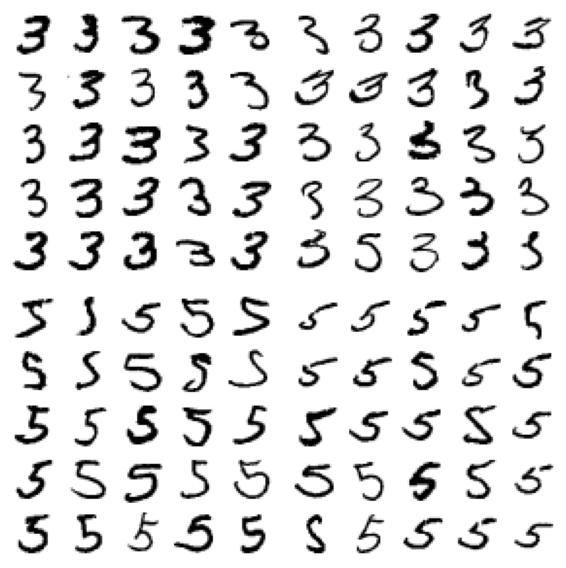

In [75]:
# hataları tek tek incelemek sınıflandırıcının neler yaptığını 
# gözlemleye yardımcı olur ancak çok zaman alır.

# örneğin sadece 3'leri ve 5'leri çizdirelim

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

Soldaki 5x5 blok 3 olarak sınıflandırılan görüntüleri sağdaki 5x5 blok 5 olarak sınıflandırılan görüntüleri gösteriyor.

## Çok Etiketli Sınıflandırma

Bazen sınıflandırıcının her örneği birden fazla sınıfa sınıflandırmasını isteyebilirsiniz. Bir yüz tanıma sınıflandırıcısı hayal edin: Bir resimde birden fazla insan tanırsa ne olacak?<br><br>
O halde modelin tanıdığı her insana bir etiket vermesi gerekir. Sınıflandırıcının `Alice`, `Bob` ve `Charlie` olmak üzere 3 yüzü tanımak için eğitildiğini varsayalım. Daha sonra sınıflandırıcıya `Alice` ve `Charlie`'nin yüzü gösterildiğinde `[1, 0, 1]` çıktısı vermelidir (`Alice` evet, `Bob` hayır, `Charlie` evet anlamına gelir).<br><br>
Çıktısı çoklu ikili etiketler olan böyle sınıflandırma sistemleri *çok etiketli sınıflandırma sistemi* olarak adlandırılır. 

In [77]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [79]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [80]:
knn_clf.predict([some_digit])

array([[False,  True]])

5 rakamı 7'ye eşit veya büyük değil (`False`)<br>
Aynı zamanda tek sayı (`True`)

Çok etiketli sınıflandırıcıları değerlendirmenin birçok yolu vardır ve doğru ölçüt seçimi tamamen projenize göre değişir. Bir yaklaşım, her bir etiket için $F_1$ skoru hesaplamak (ya da ikili sınıflandırıcılar için daha önce belirtilen ölçütlerden herhangi biri) sonra basitçe ortalamasını hesaplamaktır. 

In [82]:
# Aşağıdaki kod bütün tüm etiketlerin f1 skorunu hesaplar

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
knn_f1 = f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [83]:
knn_f1

0.976410265560605

Bu, tüm etiketlerin eşit önemde olduğunu varsayar ki durum böyle olmayabilir. Özellikle de `Alice`'in resimlerine `Bob` ya da `Charlie`'ninkilerden daha fazla sahipseniz sınıflandırıcınızın `Alice`'in resimlerinin skorlarına daha fazla ağırlık vermesini isteyebilirsiniz.<br><br>
Bir basit seçenek her etiketi desteğine (örneğin o etikete ait örneklerin sayısı) göre ağırlıklandırmaktır.<br><br>
Bunu yapabilmek için üstteki kodu `average="weighted"` olarak değiştirmek yeterlidir.

In [84]:
knn_f1_weighted = f1_score(y_multilabel, y_train_knn_pred, average="weighted")
knn_f1_weighted

0.9778357403921755

## Çok Çıktılı Sınıflandırma

Burada inceleyeceğimiz son sınıflandırma türü `çık çıktılı — çok sınıflı sınıflandırma`'dır (ya da daha basitçe *çok çıktılı sınıflandırma*). Aslında çok etiketli sınıflandırmanın, her etiketin çok sınıflı (örneğin iki olası değere sahip olabilmesidir) olabildiği türüdür.<br><br>
Bunu açıklamak için görüntülerde gürültü azaltan bir sistem inşa edelim. Girdi olarak gürültülü bir görüntü alacak ve çıktı olarak piksel değerleri dizisi olarak, aynı MNIST görüntülerinde olduğu gibi temiz bir rakam görüntüsü (umulan) verecek.<br><br>
Sınıflandırıcının çıktısı çok etiketlidir (her piksel için bir etiket) ve her etiket birden fazla değer alabilir (0'dan 255'e kadar). Bundan dolayı bu, çok çıktılı sınıflandırma sistemine birr örnektir.

**<font color='red'>NOT:</font>** Bağlanım ile sınıflandırma arasındaki çizgi bazen aynı bu örnekte olduğu gibi Muhtemeleni piksel yoğunluklarını tahmin etmek sınıflandırmadan ziyade bağlanıma daha yakın duruyor. Ayrıca, çok çıktılı sistemler sınıflandırma görevleriyle sınırlı değildir, hatta hem sınıf etiketleri hem de değer etiketleri dahil olmak üzere örnek başına birden çok etiket çıkaran bir sisteminiz bile olabilir.

In [86]:
# gürültü oluşturup ekleyelim

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


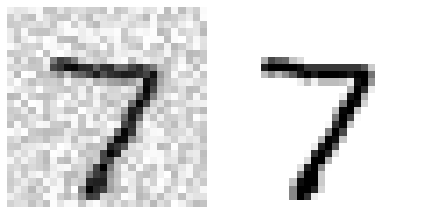

In [89]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

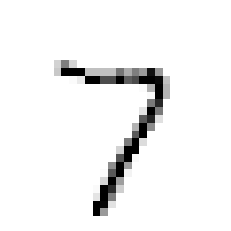

In [90]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)